In [1]:
import jax
import jax.numpy as jnp  # JAX NumPy
import optax  # Optimizers
import equinox as eqx  # Equinox

from flowMC.resource.model.common import MLP
from flowMC.resource.model.flowmatching.base import (
    Solver,
    Path,
    CondOTScheduler,
    FlowMatchingModel,
)
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [8]:
# Optimization parameters
num_epochs = 5000
batch_size = 30000
learning_rate = 1e-3
momentum = 0.9
n_samples = 30000
seed = 0

In [9]:
solver = Solver(
    MLP([3, 128, 128, 128, 2], jax.random.PRNGKey(0), activation=jax.nn.swish)
)
path = Path(CondOTScheduler())
model = FlowMatchingModel(solver, path)

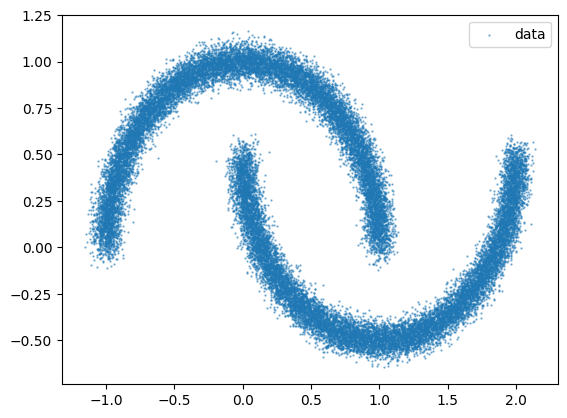

In [10]:
data = jnp.array(make_moons(n_samples, noise=0.05)[0])

plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label="data")
plt.legend()

In [11]:
key = jax.random.PRNGKey(seed)

key, subkey = jax.random.split(key)
x0 = jax.random.normal(subkey, (data.shape[0], 2))  # Initial points
key, subkey = jax.random.split(key)
t = jax.random.uniform(
    subkey, (data.shape[0], 1), minval=0.0, maxval=1.0
)  # Random time points

optim = optax.adam(learning_rate)
state = optim.init(eqx.filter(model, eqx.is_array))
key, subkey = jax.random.split(key)
key, trained_model, state, loss = model.train(
    key, (x0, data, t), optim, state, num_epochs, batch_size, verbose=True
)

Training NF:   0%|          | 0/5000 [00:00<?, ?it/s]

Compiling training step


Training NF, current loss: 0.948: 100%|██████████| 5000/5000 [00:31<00:00, 158.93it/s]


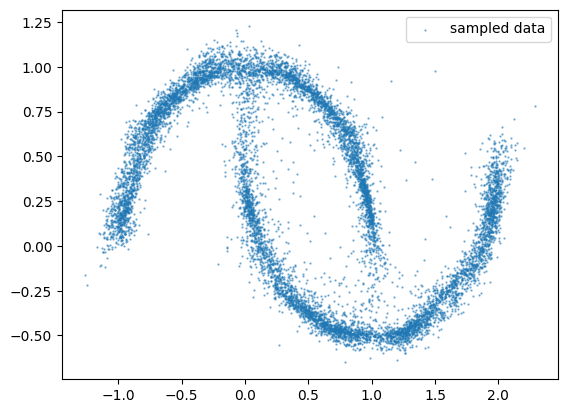

In [12]:
sampled_data = trained_model.sample(key, 10000, dt=0.1)
plt.scatter(
    sampled_data[:, 0], sampled_data[:, 1], s=0.5, alpha=0.5, label="sampled data"
)
plt.legend()
plt.show()

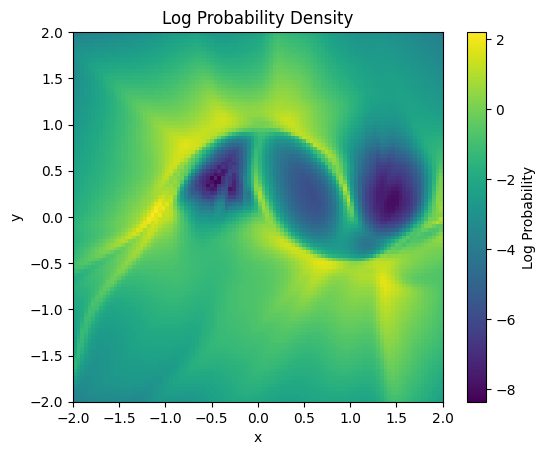

In [14]:
grid = jnp.mgrid[-2:2:100j, -2:2:100j]
grid = grid.reshape(2, -1).T  # Reshape to (10000, 2)
log_prob = eqx.filter_vmap(trained_model.log_prob, in_axes=(0,))(grid)
plt.imshow(
    log_prob.reshape(100, 100).T, extent=(-2, 2, -2, 2), origin="lower", cmap="viridis"
)
plt.colorbar(label="Log Probability")
plt.title("Log Probability Density")
plt.xlabel("x")
plt.ylabel("y")
plt.show()